# Statistical analysis on NHANES data collected between 2009 and 2012

Before starting the process, let's have a quick look to the software environment :

In [1]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] magrittr_1.5         IRdisplay_0.5.0      pbdZMQ_0.3-3        
 [4] tools_3.3.1          htmltools_0.3.6      base64enc_0.1-3     
 [7] crayon_1.3.4         Rcpp_0.12.17         uuid_0.1-2          
[10] stringi_1.2.3        IRkernel_0.8.12.9000 jsonlite_1.5        
[13] stringr_1.3.1        digest_0.6.15        repr_0.15.0         
[16] evaluate_0.10.1     

We can see that the `R version` of the Jupyter notebook is `3.3.1` and its OS is Debian GNU/Linux 8. These elements might be important if a user try to re-create the same exact software-environment.

Now, to erase all the cells output and then execute the code again, click on Kernel > Restart & clear output. Then you can execute the code by selecting a cell and clicking on the run button (or by using the shortcut Shift-Enter). You can interact with the code and edit it all along the notebook.

Some lines of code might take a few seconds or minutes to be executed.

The present notebook is divided in five parts :
1. Connection to the MRAN repository and loading of packages 
2. Query of data
3. Data management
4. Descriptive statistics
5. Statistical analysis

# 1) Connection to the MRAN repository and loading of packages 

CRAN is a package repository of the programming language R. Packages tend to get many updates over time and MRAN enable to retrieve packages with frozen versions corresponding to a specific date (in our illustration the date is set to 2018-07-06). MRAN basically consists of daily snapshots of CRAN. Extracting versions of different packages on a specific date facilitates consistency between packages and reproducibility. More information on : https://cran.r-project.org/ and https://mran.microsoft.com/ .
The line of code below sets the repository to MRAN instead of the default CRAN. (_When executing this code on binder it is facultative to run the next cell since the `runtime.txt` file in the Github repository already specifies it_)

In [2]:
options(repos = c(CRAN = "https://mran.revolutionanalytics.com/snapshot/2018-07-06"))

We can check with the line of code below that the repository used to install packages is correctly set to MRAN. You should get a URL that contains 'mran'.

In [3]:
getOption("repos")

CRAN 
"https://mran.revolutionanalytics.com/snapshot/2018-07-06"

Since the installation of every packages (except `Rcupcake` package which requires the `install_github()` function) is already done by the `install.R` file in the Github repository, there is no need to execute the `install.packages()` function here. However, for more clarity, we mentionned the line of code necessary for the installation of packages after the "#" symbol ("#" prevents the code to be executed).

### dplyr package installation

In [4]:
#install.packages("dplyr")
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### prettyR package installation

In [5]:
#install.packages("prettyR")
library(prettyR)

### knitr package installation 

In [6]:
#install.packages("knitr")
library(knitr)

### devtools package installation 

In [7]:
#install.packages("devtools")
library(devtools)

### Installation of BiocInstaller package
_This package is necessary to the installation of `Rcupcake package`. Here we specified the repository in the code because it is not part of the CRAN._

In [8]:
#install.packages("BiocInstaller", repos = "http://www.bioconductor.org/packages/3.5/bioc")
library(BiocInstaller)

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install


### Rcupcake package installation

Before starting the installation of the package you need to indicate the location of the TAR application by `/bin/tar`.

More information on how to install `Rcupcake` here : https://github.com/hms-dbmi/Rcupcake-case-studies/blob/master/NHANEScaseStudy_v01.ipynb

In [9]:
if (file.exists(Sys.getenv("TAR")) == FALSE)  {
    Sys.setenv(TAR = "/bin/tar")
}

**The installation of `Rcupcake` might take up to 10 minutes.**

In [10]:
install_github("hms-dbmi/Rcupcake", force = TRUE)
library(Rcupcake)

from URL https://api.github.com/repos/hms-dbmi/Rcupcake/zipball/master
Installing Rcupcake
'/opt/conda/lib/R/bin/R' --no-site-file --no-environ --no-save --no-restore  \
  --quiet CMD INSTALL  \
  '/tmp/RtmpLED1Iw/devtools190b51a39b412/hms-dbmi-Rcupcake-425c4b5'  \
  --library='/opt/conda/lib/R/library' --install-tests 



# 2) Query of data

Data involved in the following process are data queried from NHANES during the 2009-2012 period.

## a) Start the session

We first need to establish a connection to the database (https://nhanes.hms.harvard.edu/). To do so you first need to erase the api key in quotations and then copy and paste the BD2K PICSURE API Key instead. You can find this key by clicking on "Public user" and then "User profile" on the link provided.

Once the code executed, you should obtain this output : 'Start Session: success'

In [11]:
sessionEx <- start.session( 
              url         = "https://nhanes.hms.harvard.edu/", 
              apiKey      = "ajloq5n6ms49rufibr4nmko8s7"
              )
sessionEx

[1] "Start Session: success"

The line of code below enables to retrieve the paths of the location of each variable of interest. A vector of these 3 paths is then created.

In [12]:
nhanesDemographics <- get.children( 
   url         = "https://nhanes.hms.harvard.edu/", 
   fieldname   = "/nhanes/Demo/demographics/demographics/"
  )


nhanesFood_recall <- get.children( 
   url         = "https://nhanes.hms.harvard.edu/", 
   fieldname   = "/nhanes/Demo/questionnaire/questionnaire/food component recall/"
  )

nhanesBody_measurements <- get.children( 
   url         = "https://nhanes.hms.harvard.edu/", 
   fieldname   = "/nhanes/Demo/examination/examination/body measures/"
  )

nhanesVector <- c( nhanesDemographics, nhanesFood_recall, nhanesBody_measurements)
head(nhanesVector)

[1] "/nhanes/Demo/demographics/demographics/AGE/"      
[2] "/nhanes/Demo/demographics/demographics/area/"     
[3] "/nhanes/Demo/demographics/demographics/DMDBORN/"  
[4] "/nhanes/Demo/demographics/demographics/DMDMARTL/" 
[5] "/nhanes/Demo/demographics/demographics/education/"
[6] "/nhanes/Demo/demographics/demographics/INDFMPIR/"

## b) Build of a json query

Once the paths have been gathered, we can create the JSON query to retrieve the variables of interest.

In [13]:
query_example <- my.query( myfields  = "AGE|SEX|Body Mass Index (kg per m**2)|Waist Circumference (cm)|Sugarfree Diet", 
                          myvector  = nhanesVector, 
                          url       = "https://nhanes.hms.harvard.edu/"
              )
query_example

{
  "select": [
    {
      "field": {
        "pui": "/nhanes/Demo/demographics/demographics/AGE/",
        "dataType": "AGE"
      },
      "alias": "/nhanes/Demo/demographics/demographics/AGE/"
    },
    {
      "field": {
        "pui": "/nhanes/Demo/demographics/demographics/SEX/female/",
        "dataType": "female"
      },
      "alias": "/nhanes/Demo/demographics/demographics/SEX/"
    },
    {
      "field": {
        "pui": "/nhanes/Demo/demographics/demographics/SEX/male/",
        "dataType": "male"
      },
      "alias": "/nhanes/Demo/demographics/demographics/SEX/"
    },
    {
      "field": {
        "pui": "/nhanes/Demo/questionnaire/questionnaire/food component recall/Sugarfree Diet/",
        "dataType": "Sugarfree Diet"
      },
      "alias": "/nhanes/Demo/questionnaire/questionnaire/food component recall/Sugarfree Diet/"
    },
    {
      "field": {
        "pui": "/nhanes/Demo/examination/examination/body measures/Body Mass Index (kg per m**2)/",
        "dat

## c) Create of a dataframe from the json query

Once the json query built, we can finally create our dataframe (`nhanes_query`) that will be used to perform statistical analysis. The format (here : `csv`) and the path of the output (here : `./dataNHANES.txt`) need to be specified in the code.

Note that the creation of the dataframe might take a few minutes.

In [14]:
nhanes_query <- my.data( 
    query          = query_example,
    url            = "https://nhanes.hms.harvard.edu/", 
    responseFormat = "CSV", 
    outputPath     = "./dataNHANES.txt")

Here's a view of the six first rows of `nhanes_query` :

In [15]:
head(nhanes_query)

patient_id,X.nhanes.Demo.demographics.demographics.SEX.,X.nhanes.Demo.questionnaire.questionnaire.food.component.recall.Sugarfree.Diet.,X.nhanes.Demo.demographics.demographics.AGE.,X.nhanes.Demo.examination.examination.body.measures.Waist.Circumference..cm..,X.nhanes.Demo.examination.examination.body.measures.Body.Mass.Index..kg.per.m..2..
2,male,0,85,99.4,26.32
5,male,0,18,NA,22.58
7,male,0,31,110.1,33.09
9,male,0,52,90.2,21.10
10,male,NA,25,103.2,30.12
18,male,NA,40,100.0,28.97


 # 3) Data management

## a) Basic quick overview of the structure of variables

_Description of each variable are available in the fourth section._

In [16]:
glimpse(nhanes_query)

Observations: 41,474
Variables: 6
$ patient_id                                                                         <int> ...
$ X.nhanes.Demo.demographics.demographics.SEX.                                       <fct> ...
$ X.nhanes.Demo.questionnaire.questionnaire.food.component.recall.Sugarfree.Diet.    <int> ...
$ X.nhanes.Demo.demographics.demographics.AGE.                                       <int> ...
$ X.nhanes.Demo.examination.examination.body.measures.Waist.Circumference..cm..      <dbl> ...
$ X.nhanes.Demo.examination.examination.body.measures.Body.Mass.Index..kg.per.m..2.. <dbl> ...


We can see here that the variable names are long and cumbersome to manipulate. Plus the variable adressing the sugar fee diet (yes or no) is considered as integer instead of categorical. We will then modify these in the next steps.

## b) Modify variable names to make it more manageable

In [17]:
names(nhanes_query)

variables <- c('patient_id', 'sex', 'sugarfree_diet', 'age', 'waist_circumference', 'body_mass_index')

names(nhanes_query) <- variables

head(nhanes_query)

[1] "patient_id"                                                                        
[2] "X.nhanes.Demo.demographics.demographics.SEX."                                      
[3] "X.nhanes.Demo.questionnaire.questionnaire.food.component.recall.Sugarfree.Diet."   
[4] "X.nhanes.Demo.demographics.demographics.AGE."                                      
[5] "X.nhanes.Demo.examination.examination.body.measures.Waist.Circumference..cm.."     
[6] "X.nhanes.Demo.examination.examination.body.measures.Body.Mass.Index..kg.per.m..2.."

patient_id,sex,sugarfree_diet,age,waist_circumference,body_mass_index
2,male,0,85,99.4,26.32
5,male,0,18,NA,22.58
7,male,0,31,110.1,33.09
9,male,0,52,90.2,21.10
10,male,NA,25,103.2,30.12
18,male,NA,40,100.0,28.97


## c)Transform the variable `sugarfree_diet` into a categorical variable and label it

In [18]:
nhanes_query$sugarfree_diet <- factor(nhanes_query$sugarfree_diet, levels=c('0','1'), labels=c('No','Yes'))

# 4) Descriptive statistics

Here's a view of the six first rows of `nhanes_query` now that we modified the variables:

In [19]:
head(nhanes_query)

patient_id,sex,sugarfree_diet,age,waist_circumference,body_mass_index
2,male,No,85,99.4,26.32
5,male,No,18,NA,22.58
7,male,No,31,110.1,33.09
9,male,No,52,90.2,21.10
10,male,NA,25,103.2,30.12
18,male,NA,40,100.0,28.97


## a) Description of variables

- `patient_id` : anonymous unique identifier of individuals
- `sex` : male / female
- `high_fiber_diet` : yes (the individual has a high fiber diet) / no (the individual does not have a high fiber diet)
- `age` : age of individuals in years
- `waist_circumference` : waist circumference of indviduals in cm
- `body_mass_index` : Body mass index of individual in kg/m^2

Below you can see a basic summary statistics of our dataset :

In [20]:
describe(nhanes_query[, -1], num.desc = c("mean", "sd", "median", "min", "max", "valid.n"))

Description of nhanes_query[, -1] 



 Numeric 
                     mean    sd median   min    max valid.n
age                 29.25 24.80   19.0  0.00  85.00   41474
waist_circumference 85.04 21.01   85.3 32.00 175.00   34409
body_mass_index     24.94  7.19   24.2  7.99 130.21   35108

 Factor 
         
sex         female     male
  Count   21210.00 20264.00
  Percent    51.14    48.86
Mode female 
              
sugarfree_diet     <NA>       No    Yes
       Count   21881.00 19482.00 111.00
       Percent    52.76    46.97   0.27
Mode NA 

## b) Gender distribution

In [21]:
gender_distribution <- table(nhanes_query$sex)

gender_distribution


female   male 
 21210  20264 

In [22]:
gender_proportion<- round(100*gender_distribution/sum(gender_distribution), 1)

gender_proportion


female   male 
  51.1   48.9 

There are 21210 females (51.1%) and 20264 males (48.9%).

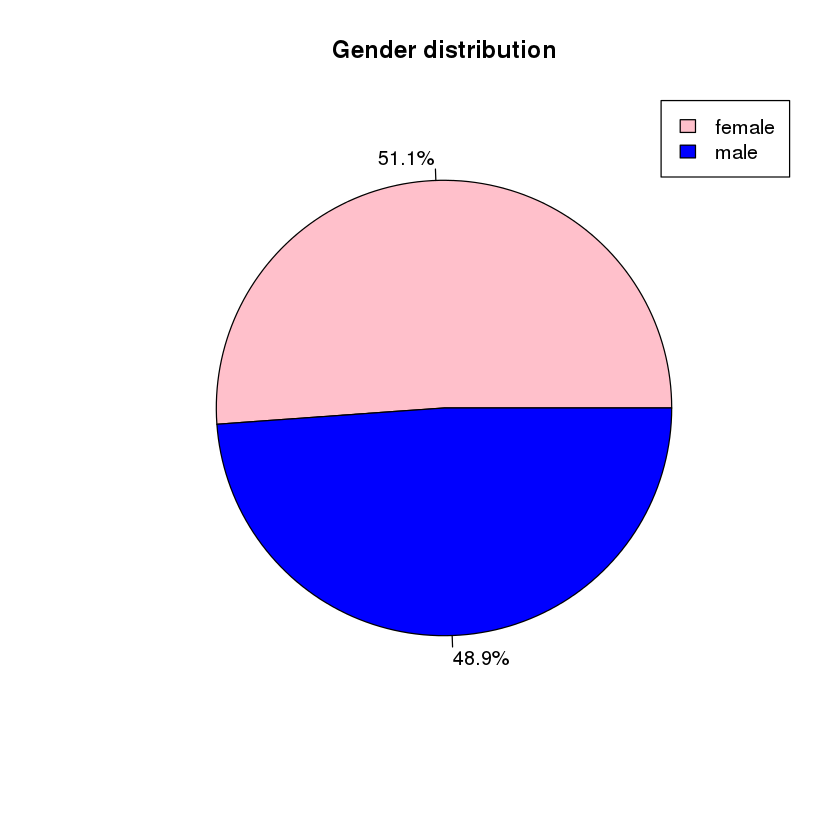

In [23]:
gender_percent <- paste(gender_proportion,"%",sep="")

pie(gender_distribution, labels = gender_percent, main = "Gender distribution", col = c("pink", "blue"))
legend("topright", c("female", "male"), fill = c("pink", "blue"))

## c) Age according to gender distribution

sex,first_quantile_age,median_age,third_quantile_age
female,10,20,47.00
male,9,19,47.25


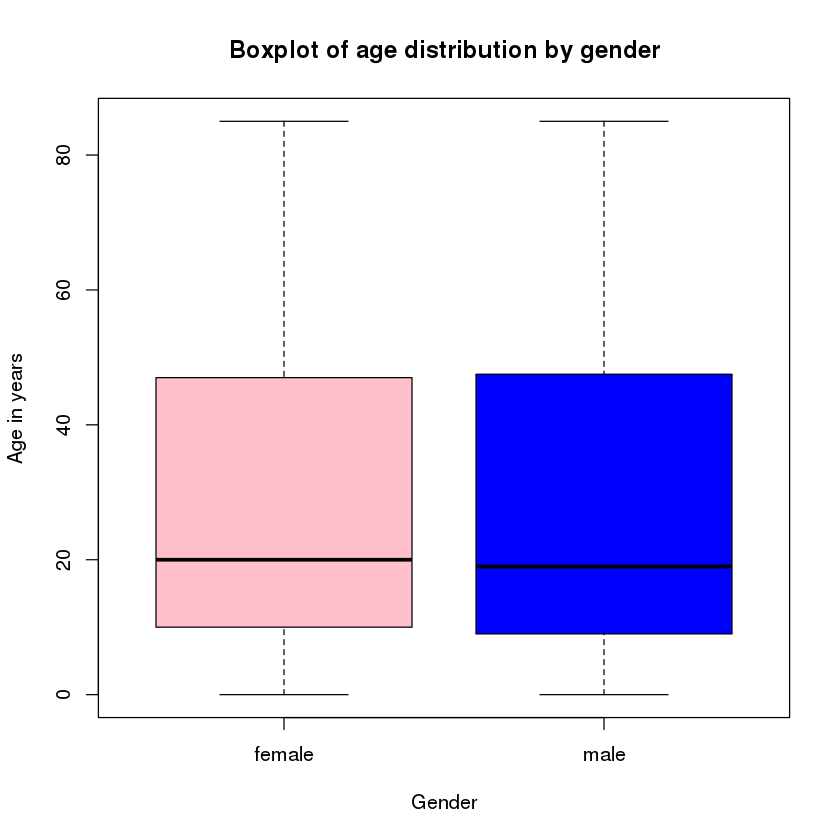

In [24]:
nhanes_query %>% group_by(sex)%>% summarise(first_quantile_age = quantile(age, probs = 0.25, na.rm = TRUE), median_age = median(age, na.rm = TRUE), third_quantile_age = quantile(age, probs = 0.75, na.rm = TRUE))

boxplot(age~sex, data = nhanes_query, main = "Boxplot of age distribution by gender", xlab = "Gender", ylab = "Age in years", col = c("pink", "blue"))

The output above shows similar distributions of age in males and females.

## d) Body mass index (BMI) according to gender

sex,first_quantile_bmi,median_bmi,third_quantile_bmi
female,19.64,24.22,29.73
male,19.30,24.17,28.60


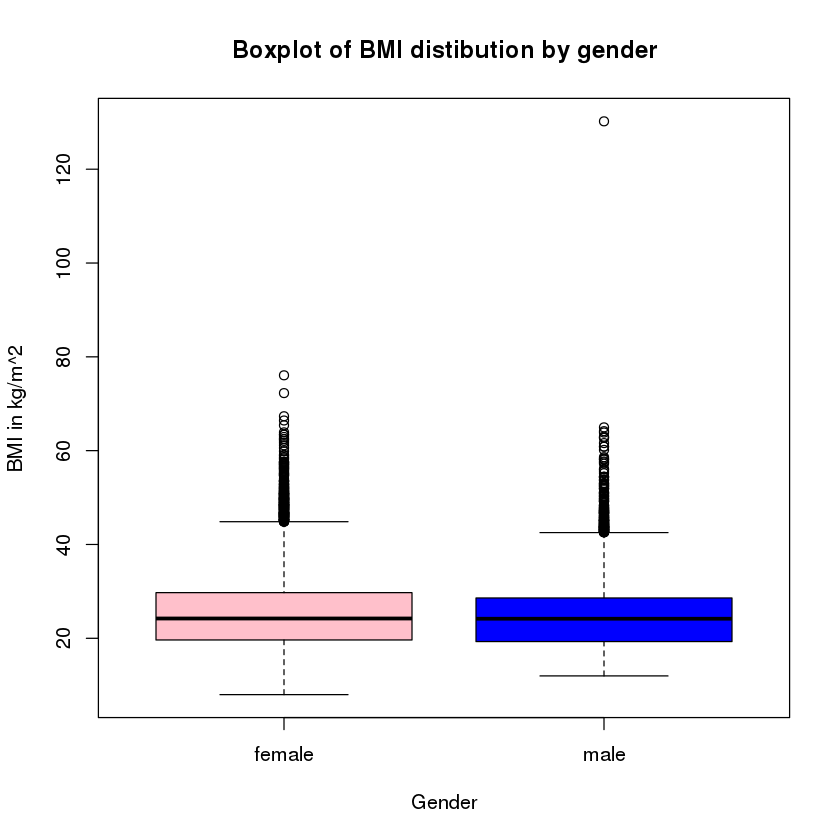

In [25]:
nhanes_query %>% group_by(sex)%>% summarise(first_quantile_bmi = quantile(body_mass_index, probs = 0.25, na.rm = TRUE), median_bmi = median(body_mass_index, na.rm = TRUE), third_quantile_bmi = quantile(body_mass_index, probs = 0.75, na.rm = TRUE))

boxplot(body_mass_index~sex, data = nhanes_query, main = "Boxplot of BMI distibution by gender", xlab = "Gender", ylab = "BMI in kg/m^2", col = c("pink", "blue"))

BMI distribution of females is slightly more widespread than males distribution.

# 5) Statistical analysis

We are here exploring if there is a relationship between having a sugarfree diet and the waist circumference. In this study, measurements are performed for individuals over 2 years old.

Note first with the next line of code that there are no missing values for the variable `age`.

In [26]:
table(is.na(nhanes_query$age))


FALSE 
41474 

For better clarity, let's subset a new dataset comprising only those individuals.

In [27]:
nhanes_over_two <- nhanes_query %>% filter(age >=2)

In [28]:
#quick check of the number of observations and variables
dim(nhanes_over_two)

[1] 38124     6

We have now generated our new dataset with 38 124 observations (individuals over 2 years old) and the same 6 variables from the previous dataset.
You can see below a basic statistics summary :

In [29]:
describe(nhanes_over_two[, -1], num.desc = c("mean", "sd", "median", "min", "max", "valid.n"))

Description of nhanes_over_two[, -1] 



 Numeric 
                     mean    sd median   min    max valid.n
age                 31.79 24.28   23.0  2.00  85.00   38124
waist_circumference 85.05 21.01   85.3 32.00 175.00   34408
body_mass_index     24.94  7.19   24.2  7.99 130.21   35108

 Factor 
         
sex         female     male
  Count   19636.00 18488.00
  Percent    51.51    48.49
Mode female 
              
sugarfree_diet     <NA>       No    Yes
       Count   20183.00 17831.00 110.00
       Percent    52.94    46.77   0.29
Mode NA 

We can see that there are missing values in every variables except from `age` and `sex`.

**Missing values in `sugarfree_diet` and `waist_circumference` respectively represent more than 50% and around 10% of the observations.**

## a) Previous assumptions checking before the t-test analysis

### Is the distribution normal ?

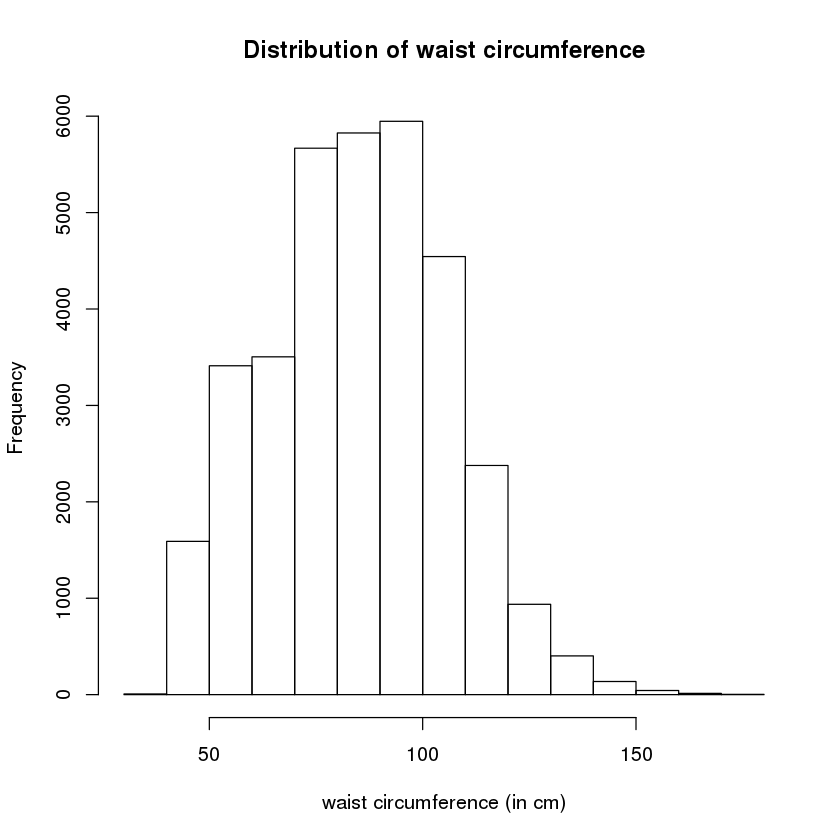

In [30]:
hist(nhanes_over_two$waist_circumference, xlab = "waist circumference (in cm)", main = "Distribution of waist circumference")

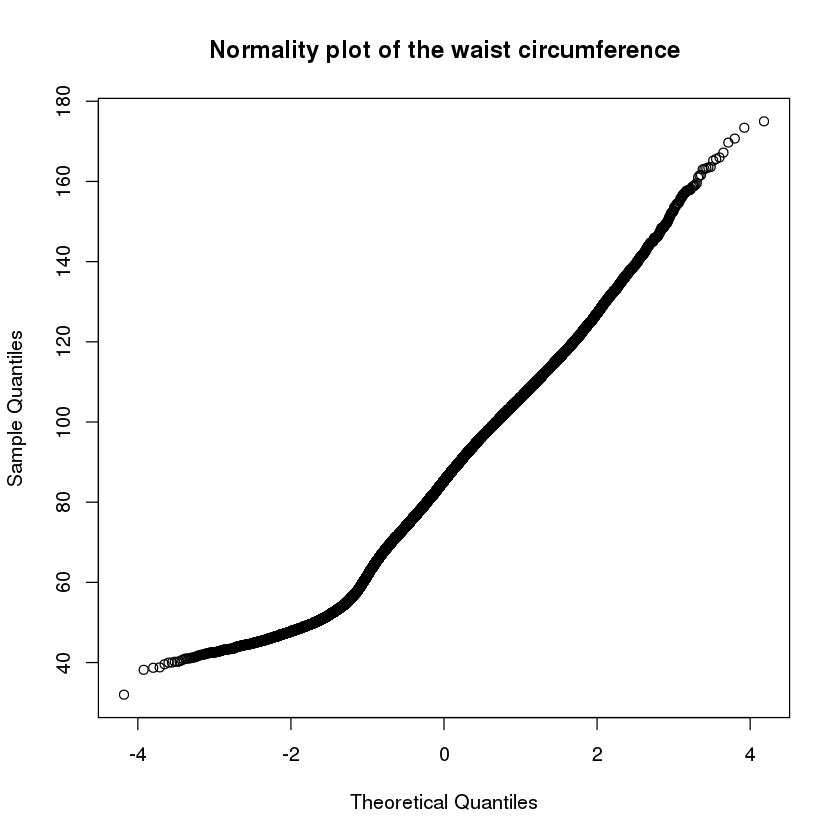

In [31]:
qqnorm(nhanes_over_two$waist_circumference, main = "Normality plot of the waist circumference")

We can see on both the histogram and the normality plot that the distribution is skwewed on the left side (_some very small waist circumferences are physiologically impossible_) but we admit that its distribution is overall normal.

### Is the variance constant accross groups ?

In [32]:
by(nhanes_over_two$waist_circumference, nhanes_over_two$sugarfree_diet, sd, na.rm = TRUE)

nhanes_over_two$sugarfree_diet: No
[1] 21.39041
------------------------------------------------------------ 
nhanes_over_two$sugarfree_diet: Yes
[1] 19.93034

The gap between both variances is small, we admit the equal variance condition.

## b) What are the means of waist circumference in both groups ?

In [33]:
nhanes_over_two %>% group_by(sugarfree_diet)%>% summarise(count = n(), mean = mean(waist_circumference, na.rm = TRUE))

sugarfree_diet,count,mean
No,17831,85.42428
Yes,110,100.86698
NA,20183,84.57783


It is important to take into consideration that **3716** observations with missing values in `waist_circumference` were exluded (`na.rm = TRUE`) in order to compute means (_run the code below to get this number_).

In [34]:
nhanes_over_two %>% filter(is.na(nhanes_over_two$waist_circumference))%>% nrow()

[1] 3716

## c) Statistical test ( independent 2-group t-test )

In [35]:
t.test(waist_circumference~sugarfree_diet, var.equal = TRUE, data = nhanes_over_two)


	Two Sample t-test

data:  waist_circumference by sugarfree_diet
t = -7.4128, df = 17067, p-value = 1.295e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -19.52609 -11.35930
sample estimates:
 mean in group No mean in group Yes 
         85.42428         100.86698 


The output above shows a statistically significant association between having a sugarfree diet and the waist circumference ( IC95 = [11,4; 19.5]; p< 0.001) in our sample of individuals over 2 years old with no imputation for missing values. People under a sugarfee diet tend to have a higher waist circumference in this sample.
We can not draw any causality statement from this analysis since the design of the study (observational study) does not allow it. Plus it is important to stress the weakness of the results due to the high number of missing values.

**This notebook is only intended as an illustration of a basic statistical analysis in our attempt to create a reproducible and F.A.I.R (findable, accessible, interoperable and reusable) statistical analysis.**